In [1]:
import numpy as np
import pandas as pd
import random

from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GRU, Input, BatchNormalization, Dropout
from ncps.wirings import AutoNCP
from ncps.keras import LTC

2026-02-03 00:27:09.260066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770067629.276015    8434 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770067629.282387    8434 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770067629.303139    8434 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770067629.303166    8434 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770067629.303168    8434 computation_placer.cc:177] computation placer alr

# Configuration

In [2]:
NUM_EPOCHS = 483
NUM_EXPERIMENTS = 1

def create_model(train):
    model = Sequential()
    model.add(Input(shape=(train.shape[1], train.shape[2])))

    model.add(Dropout(0.2))
    model.add(GRU(20, return_sequences=True))

    model.add(Dropout(0.2))
    model.add(GRU(20, return_sequences=True))

    model.add(Dropout(0.2))
    model.add(GRU(10, return_sequences=True))

    model.add(Dropout(0.2))
    model.add(GRU(10, return_sequences=False))

    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.002, weight_decay=1e-7), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

# Experiment

In [3]:
ID = ["ID"]
USER = ["SubjectID"]
IDS = ["SubjectID", "VideoID"]
TARGET = ["predefinedlabel"]
FEATURES = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2"]
INIT_SEED = 6412

In [4]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/data")
data = pd.read_csv(data_dir / "EEG_data.csv")

data["ID"] = (len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]).astype("int")
data = data[ID + USER + FEATURES + TARGET]

data.head(3)

,ID,SubjectID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel
0,0,0.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,0,0.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,0,0.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0


In [5]:
def reshape_dataset(data):
    features = []
    target = []
    for cur_id in np.unique(data[ID].to_numpy()):
        cur_id_data = data[data[ID].to_numpy() == cur_id]
        target.append(np.mean(cur_id_data[TARGET].to_numpy()).astype("int"))
        features.append(cur_id_data[FEATURES].to_numpy())

    features = pad_sequences(features)
    return np.array(features), np.array(target)

def pad_sequences(arrays, pad_value=0):
    max_length = max(arr.shape[0] for arr in arrays)
    padded_arrays = [
        np.pad(
            arr,
            ((0, max_length - arr.shape[0]), (0, 0)),
            mode='constant',
            constant_values=pad_value)
            for arr in arrays
        ]
    return np.stack(padded_arrays)

In [6]:
X, _ = reshape_dataset(data)
model = create_model(X)
model.summary()

2026-02-03 00:27:17.389364: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 144, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 144, 20)        │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 144, 20)        │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 144, 10)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 144, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,061 (23.68 KB)

 Trainable params: 6,061 (23.68 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
%%time

all_acc = []
all_loss = []
all_auc = []

all_val_acc = []
all_val_loss = []
all_val_auc = []

for j, seed in tqdm(enumerate(np.arange(NUM_EXPERIMENTS) + INIT_SEED)):
    np.random.seed(int(seed))
    random.seed(int(seed))
    tf.random.set_seed(int(seed))

    train_id = np.random.choice(np.unique(np.ravel(data[USER])), 7, replace=False)
    train_index = np.isin(data[USER], train_id)

    train = data.iloc[train_index]
    test = data.iloc[~train_index]

    X_train, y_train = reshape_dataset(train)
    X_test, y_test = reshape_dataset(test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    model = create_model(X_train)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=NUM_EPOCHS,
        batch_size=10,
        verbose=1,
    )

    acc = history.history['accuracy']
    loss = history.history['loss']
    auc = history.history['auc']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    val_auc = history.history['val_auc']

    all_acc.append(acc)
    all_loss.append(loss)
    all_auc.append(auc)

    all_val_acc.append(val_acc)
    all_val_loss.append(val_loss)
    all_val_auc.append(val_auc)

epoch_acc = np.mean(all_acc, axis=0)
epoch_loss = np.mean(all_loss, axis=0)
epoch_auc = np.mean(all_auc, axis=0)

epoch_val_acc = np.mean(all_val_acc, axis=0)
epoch_val_loss = np.mean(all_val_loss, axis=0)
epoch_val_auc = np.mean(all_val_auc, axis=0)

0it [00:00, ?it/s]

Epoch 1/483
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.5616 - auc: 0.6588 - loss: 0.6795 - val_accuracy: 0.7667 - val_auc: 0.7778 - val_loss: 0.6264
Epoch 2/483
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7185 - auc: 0.6860 - loss: 0.6359 - val_accuracy: 0.7667 - val_auc: 0.7778 - val_loss: 0.5807
Epoch 3/483
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7185 - auc: 0.7209 - loss: 0.6042 - val_accuracy: 0.7667 - val_auc: 0.7667 - val_loss: 0.5384
Epoch 4/483
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7185 - auc: 0.6711 - loss: 0.5771 - val_accuracy: 0.7667 - val_auc: 0.7667 - val_loss: 0.5050
Epoch 5/483
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7185 - auc: 0.6388 - loss: 0.5763 - val_accuracy: 0.7667 - val_auc: 0.7667 - val_loss: 0.4756
Epoch 6/483
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7185 - auc: 0.7129 - loss: 0.5692 - val_accuracy: 0.8000 - val_auc: 0.7556 - val_loss: 0.4543
Epoch 7/483
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/

1it [05:36, 336.71s/it]

CPU times: user 13min 8s, sys: 5min 50s, total: 18min 58s
Wall time: 5min 36s


In [25]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib as mpl

def plot_time_series_with_shap_run_multiple_times(model, X_train, X_test, y_test, j, feature_names, lags=None, iterations=100, save_path="shap_timeseries.pdf"):
    # Apply global Matplotlib style (same as in plot_metrics)
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times", "DejaVu Serif", "Computer Modern Roman"],
        "text.usetex": False,
        "axes.labelsize": 16,
        "axes.titlesize": 17,
        "legend.fontsize": 14
    })
    label_map = {
        "Delta": r"$\delta$",
        "Theta": r"$\theta$",
        "Alpha1": r"$\alpha_{1}$",
        "Alpha2": r"$\alpha_{2}$",
        "Beta1": r"$\beta_{1}$",
        "Beta2": r"$\beta_{2}$",
        "Gamma1": r"$\gamma_{1}$",
        "Gamma2": r"$\gamma_{2}$",
        "predefinedlabel": r"$y$"
    }

    X_sample, y_sample = X_test[j], y_test[j]
    background = X_train

    shap_values = np.zeros(X_sample.shape)
    explainer = shap.GradientExplainer(model, background)
    for id_it in tqdm(range(iterations)):
        salt = 394
        shap_values_it = explainer.shap_values(np.expand_dims(X_sample, axis=0), rseed=salt + id_it)[0]
        shap_values_it = np.squeeze(shap_values_it)

        num_features = len(feature_names)
        if lags is not None:
            num_features = int(num_features / (1 + len(lags)))
            shap_values_it = shap_values_it.reshape(-1, 1 + len(lags), num_features)

            for k, lag in enumerate(lags):
                shap_values_it[:, k + 1, :] = np.roll(shap_values_it[:, k + 1, :], shift=lag, axis=0)
                shap_values_it[:lag, k + 1, :] = 0
            shap_values_it = np.sum(shap_values_it, axis=1)
        shap_values += shap_values_it / iterations

    plt.figure(figsize=(16, 6))  # same as in plot_metrics

    red_colors = cm.Reds(np.linspace(0.2, 0.9, num_features))
    blue_colors = cm.Blues(np.linspace(0.2, 0.9, num_features))
    
    scatter_plots = []
    for i in range(num_features):
        cur_feature_shap_values = shap_values[:, i]
        ts = np.arange(X_sample.shape[0])
        c = [red_colors[i] if el > 0 else blue_colors[i] for el in cur_feature_shap_values]
        s = [100000 * np.log(1 + np.abs(el)) for el in cur_feature_shap_values]
        
        plt.scatter(ts, X_sample[:, i], color=c, s=s)
        scatter_plots.append((red_colors[i], blue_colors[i], feature_names[i]))
    
    raw_prediction = model.predict(np.expand_dims(X_sample, axis=0))

    plt.yscale('log')
    plt.xlabel("Timestep")
    plt.ylabel("Feature Value (Log Scale)")
    plt.grid(True)

    # Custom legend (styled consistently)
    legend_handles = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=red, markersize=12, label=label_map[name])
        for red, blue, name in scatter_plots
    ] + [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markersize=12)
        for _, blue, _ in scatter_plots
    ]
    legend_labels = [label_map[name] for _, _, name in scatter_plots] + [label_map[name] for _, _, name in scatter_plots]

    plt.legend(
        handles=legend_handles, labels=legend_labels,
        loc='center left', bbox_to_anchor=(1.02, 0.5),
        frameon=False, ncol=2, handletextpad=1.5
    )


    plt.title(f"Sample {j}. True value '{'Confused' if y_sample == 1 else 'Not Confused'}'. "
              f"Predicted 1 with {np.round(raw_prediction[0][0] * 100, 2)}% confidence")

    plt.tight_layout()

    # Save as high-resolution PDF (same as in plot_metrics)
    plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=1200)
    plt.show()
    return shap_values


  0%|          | 0/500 [00:00<?, ?it/s]/home/aseliverstov/projects/brain_signals/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_56
Received: inputs=['Tensor(shape=(1, 144, 8))']
  warnings.warn(msg)
/home/aseliverstov/projects/brain_signals/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_56
Received: inputs=['Tensor(shape=(50, 144, 8))']
  warnings.warn(msg)
100%|██████████| 500/500 [13:17<00:00,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


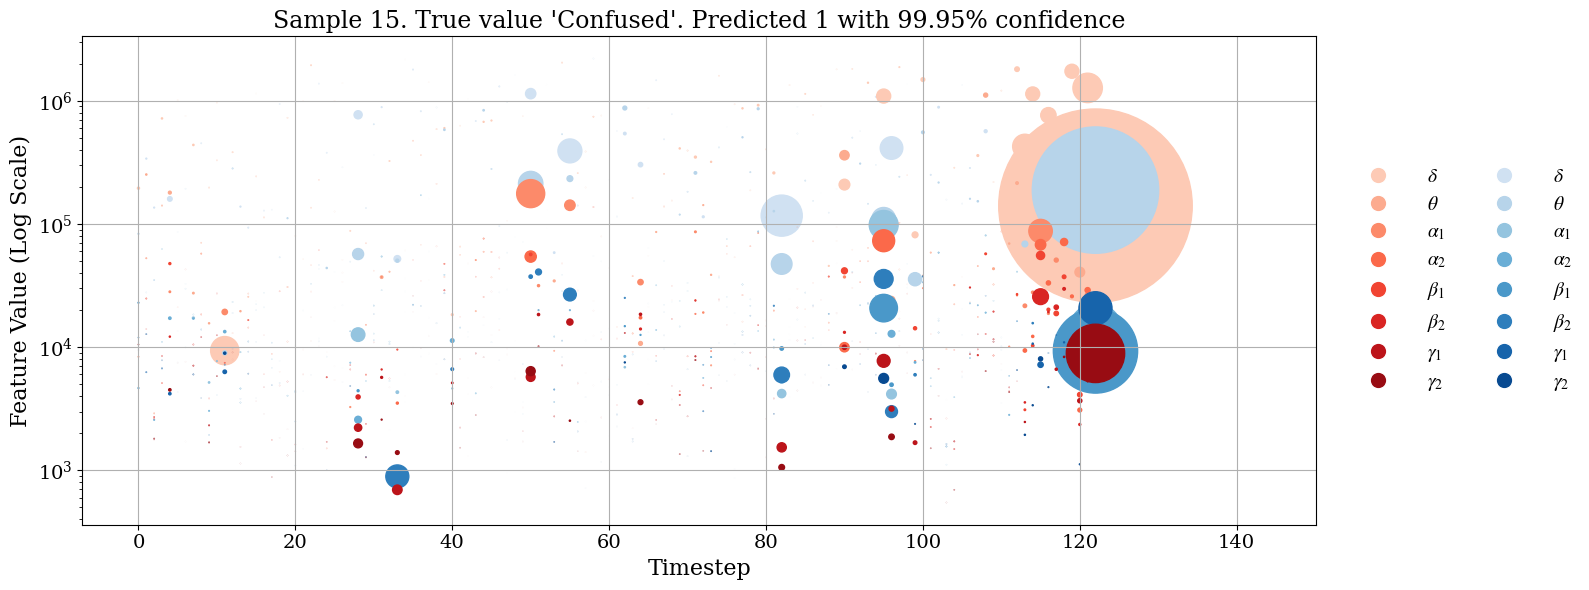

  0%|          | 0/500 [00:00<?, ?it/s]/home/aseliverstov/projects/brain_signals/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_56
Received: inputs=['Tensor(shape=(1, 144, 8))']
  warnings.warn(msg)
/home/aseliverstov/projects/brain_signals/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_56
Received: inputs=['Tensor(shape=(50, 144, 8))']
  warnings.warn(msg)
100%|██████████| 500/500 [13:35<00:00,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


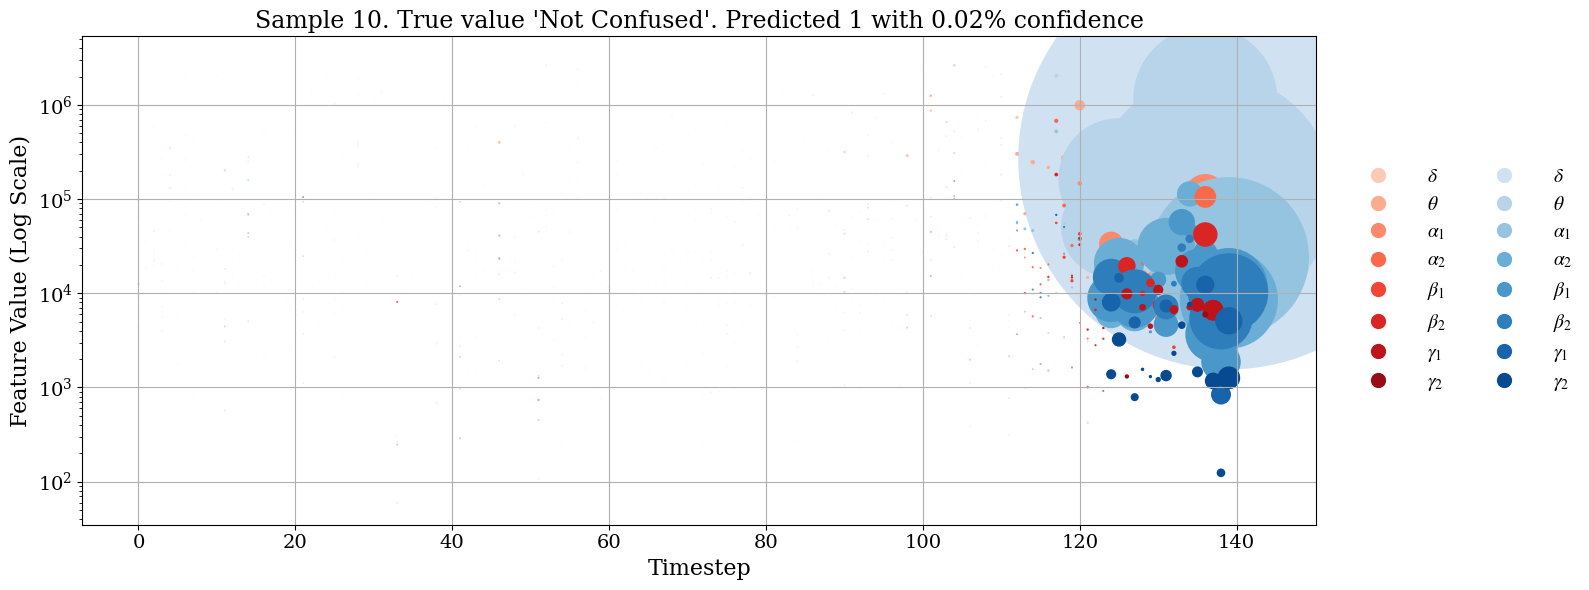

In [27]:
shap_values_15 = plot_time_series_with_shap_run_multiple_times(model, X_train, X_test, y_test, 15, FEATURES, iterations=500, save_path="../../assets/shap_timeseries_averaged_sample15.pdf")
shap_values_10 = plot_time_series_with_shap_run_multiple_times(model, X_train, X_test, y_test, 10, FEATURES, iterations=500, save_path="../../assets/shap_timeseries_averaged_sample10.pdf")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_feature_importance_from_shap(
    shap_values,
    feature_names,
    save_path="feature_importance.pdf"
):
    # ---- Global style (Times New Roman, journal-ready) ----
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "mathtext.fontset": "stix",
        "axes.unicode_minus": False,
        "axes.labelsize": 16,
        "axes.titlesize": 17,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14
    })

    # ---- Greek label mapping ----
    label_map = {
        "Delta": r"$\delta$",
        "Theta": r"$\theta$",
        "Alpha1": r"$\alpha_{1}$",
        "Alpha2": r"$\alpha_{2}$",
        "Beta1": r"$\beta_{1}$",
        "Beta2": r"$\beta_{2}$",
        "Gamma1": r"$\gamma_{1}$",
        "Gamma2": r"$\gamma_{2}$",
        "predefinedlabel": r"$y$"
    }

    # Apply label mapping
    mapped_features = [label_map.get(f, f) for f in feature_names]

    # ---- Compute mean absolute SHAP values ----
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

    # ---- Sort by importance ----
    sorted_idx = np.argsort(mean_abs_shap)
    sorted_features = [mapped_features[i] for i in sorted_idx]
    sorted_values = mean_abs_shap[sorted_idx]

    # ---- Plot ----
    plt.figure(figsize=(10, 6))

    plt.barh(
        range(len(sorted_features)),
        sorted_values,
        color="#4C72B0",      # muted academic blue
        edgecolor="black",
        linewidth=0.6
    )

    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel(r"Mean $|\mathrm{SHAP}|$ value")
    plt.title("Feature Importance", pad=10)

    plt.tight_layout()
    plt.savefig(save_path, format="pdf", dpi=1200, bbox_inches="tight")
    plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

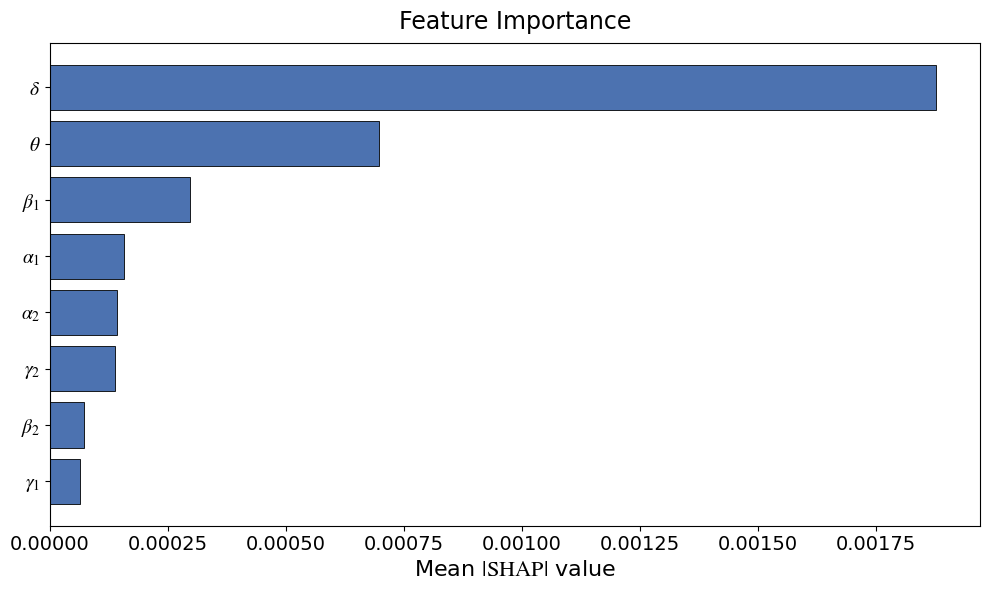

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

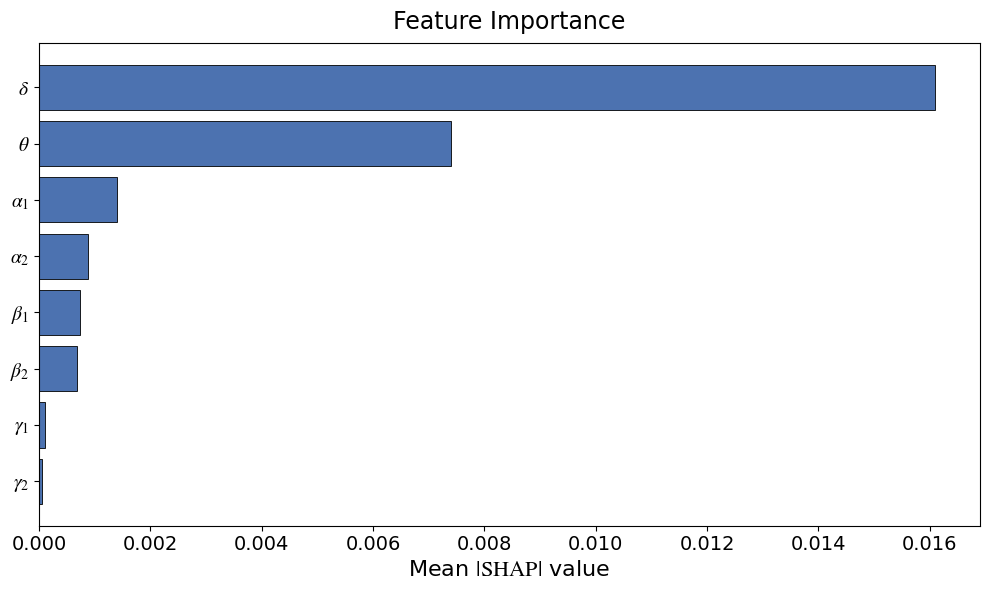

In [11]:
plot_feature_importance_from_shap(shap_values_15, feature_names=FEATURES, save_path="../../assets/shap_averaged_sample15.pdf")
plot_feature_importance_from_shap(shap_values_10, feature_names=FEATURES, save_path="../../assets/shap_averaged_sample10.pdf")